# Import libraries

In [1]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [2]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.14.0


In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Load and process data

In [7]:
# Load the data from the files
training_data = np.load('training/training_data.npy')
valid_periods = np.load('training/valid_periods.npy')
categories = np.load('training/categories.npy')

training_data.shape, valid_periods.shape, categories.shape

((48000, 2776), (48000, 2), (48000,))

In [8]:
# Convert training_data and categories to DataFrame
data_df = pd.DataFrame(training_data, columns=[f'Timestep_{i+1}' for i in range(training_data.shape[1])])
categories_df = pd.DataFrame(categories, columns=['Category'])

# Concatenate DataFrames along the columns
df = pd.concat([data_df, categories_df], axis=1)

# Display the resulting DataFrame
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48000 entries, 0 to 47999
Columns: 2777 entries, Timestep_1 to Category
dtypes: float64(2776), object(1)
memory usage: 1017.0+ MB


,Timestep_1,Timestep_2,Timestep_3,Timestep_4,Timestep_5,Timestep_6,Timestep_7,Timestep_8,Timestep_9,Timestep_10,...,Timestep_2767,Timestep_2768,Timestep_2769,Timestep_2770,Timestep_2771,Timestep_2772,Timestep_2773,Timestep_2774,Timestep_2775,Timestep_2776
count,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,...,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000
mean,0.000004,0.000004,0.000004,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,...,0.515814,0.520281,0.528503,0.533299,0.530825,0.525855,0.522132,0.523433,0.530226,0.531927
std,0.000837,0.000813,0.000781,0.000760,0.000757,0.000749,0.000745,0.000741,0.000741,0.000733,...,0.288777,0.289387,0.287716,0.288655,0.289785,0.291925,0.296271,0.302170,0.303567,0.304784
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.260870,0.265976,0.275296,0.276525,0.269440,0.259259,0.246887,0.242881,0.246772,0.244700
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.529901,0.535941,0.546886,0.556100,0.552312,0.544393,0.542242,0.550017,0.561833,0.564695
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.774056,0.781060,0.788449,0.795617,0.794872,0.793385,0.794734,0.802337,0.809368,0.815334
max,0.183319,0.178061,0.171051,0.166542,0.165793,0.164041,0.163324,0.162288,0.162288,0.160536,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


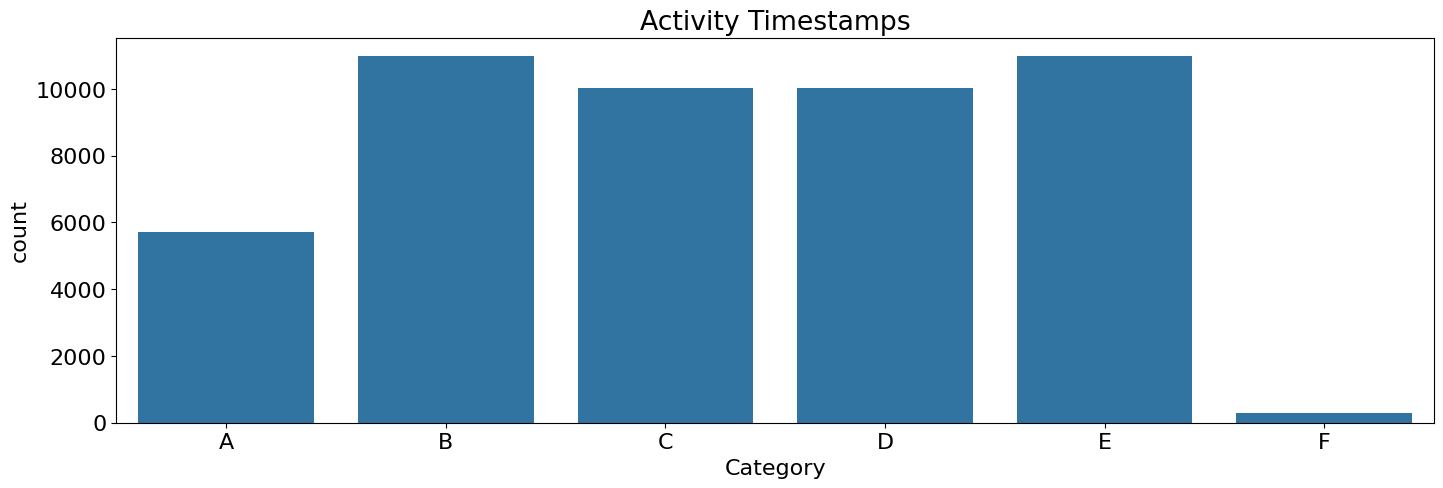

In [9]:
# Inspect activities timestamps
plt.figure(figsize=(17,5))
sns.countplot(x = 'Category', data = df, order = sorted(df['Category'].unique()))
plt.title('Activity Timestamps')
plt.show()

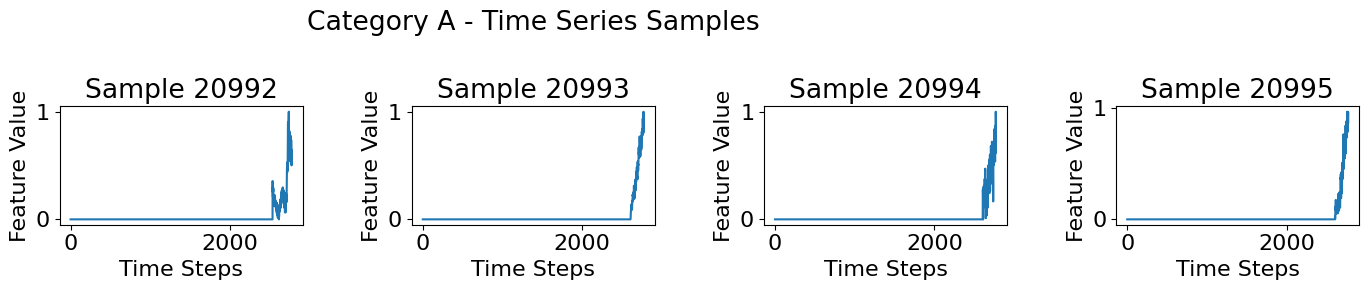

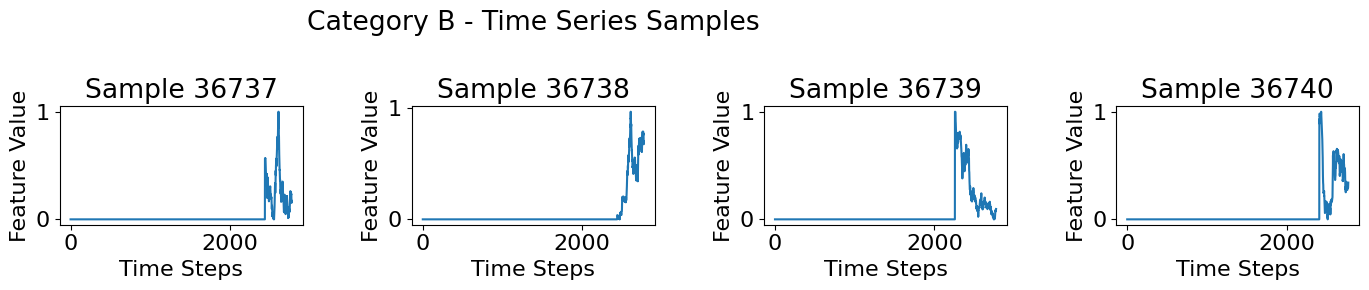

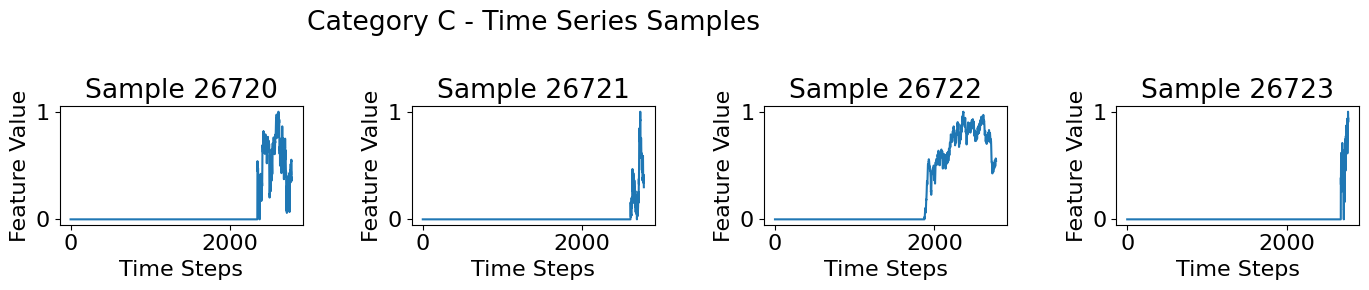

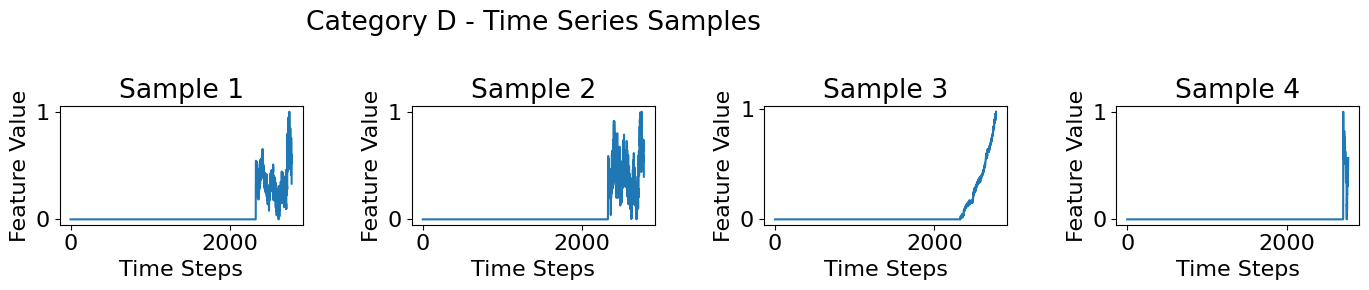

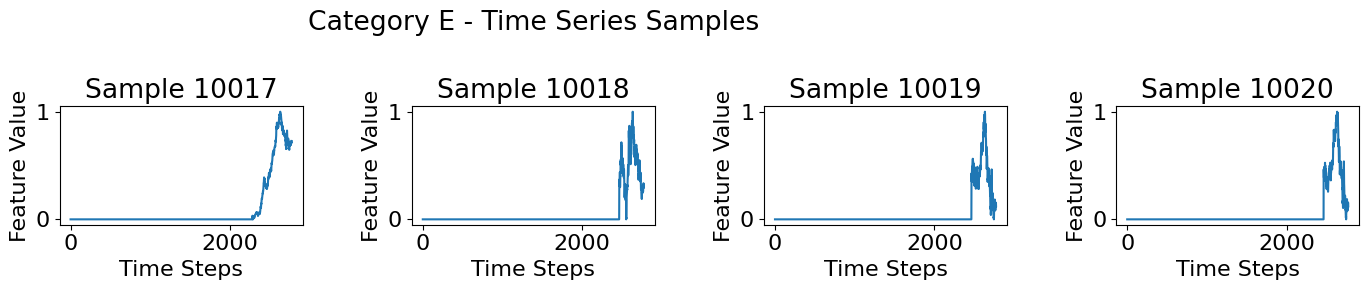

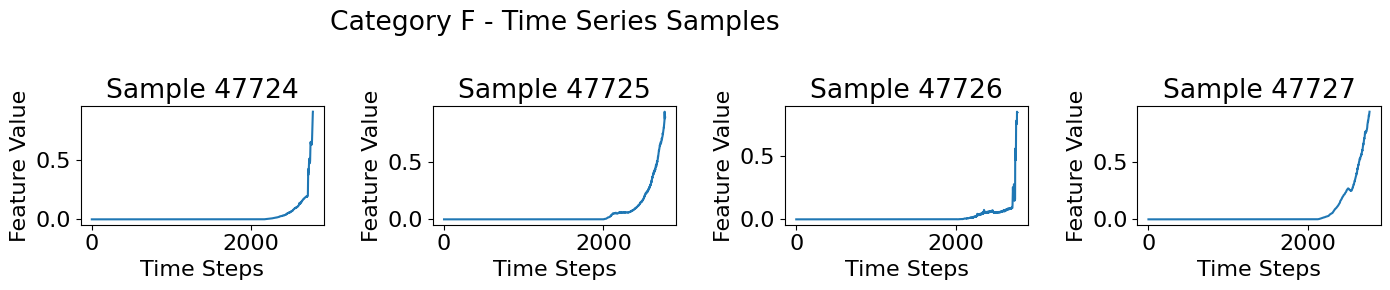

In [10]:
# Plot some samples
for category in "ABCDEF":
    to_be_inspected = 4

    plt.figure(figsize=(17, 3))  # Adjust the figure size as needed
    plt.suptitle(f'Category {category} - Time Series Samples')

    for idx in range(len(training_data)):
        if to_be_inspected == 0:
            break

        if categories[idx] != category:
            continue

        plt.subplot(1, 5, 6 - to_be_inspected)  # 1 row, 5 columns, and the current plot position
        plt.plot(training_data[idx])
        plt.title(f'Sample {idx + 1}')
        plt.xlabel('Time Steps')
        plt.ylabel('Feature Value')

        to_be_inspected -= 1

    plt.tight_layout()  # Adjust layout for better appearance
    plt.show()


## Split, Encode and Normalize

In [11]:
features = df.drop('Category', axis=1)
target = df['Category']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, stratify=target, random_state=42)

# Display the shapes of the resulting sets
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (38400, 2776) (38400,)
Testing set shape: (9600, 2776) (9600,)


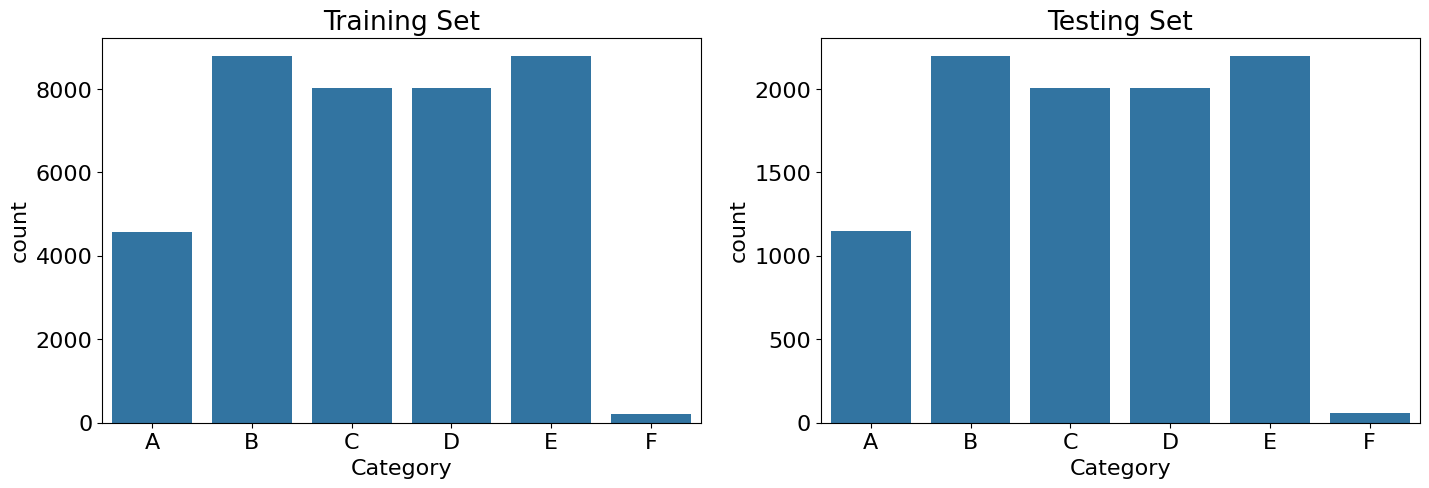

In [12]:
# Plot for training set
plt.figure(figsize=(17, 5))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, and the first plot
sns.countplot(x=y_train, order=sorted(y_train.unique()))
plt.title('Training Set')

# Plot for testing set
plt.subplot(1, 2, 2)  # 1 row, 2 columns, and the second plot
sns.countplot(x=y_test, order=sorted(y_test.unique()))
plt.title('Testing Set')

plt.show()

In [13]:
# Map categories to integers
category_mapping = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5}

y_train = y_train.map(category_mapping)
y_test = y_test.map(category_mapping)

Have you thought about further normalising your time series? In the end, they are only scaled between 0 and 1. Speaking of which, ever heard of robust scalers? (PS: remember to de-normalise in the prediction function).

In [14]:
from sklearn.preprocessing import RobustScaler

# Initialize the RobustScaler
scaler = RobustScaler()

# Fit the scaler on the training data and transform both training and testing data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [15]:
from tensorflow.keras.utils import to_categorical

forecasting_period_phase1 = 9
forecasting_period_phase2 = 18

y_train = to_categorical(y_train, num_classes=forecasting_period_phase1)
y_test = to_categorical(y_test, num_classes=forecasting_period_phase1)

# Build and train models

In [19]:
input_shape = X_train.shape[1:]
classes = y_train.shape[-1]
batch_size = 128
epochs = 200

forecasting_period_phase1 = 9
forecasting_period_phase2 = 18

input_shape, classes, X_train.shape

((2776,), 9, (38400, 2776))

# Vanilla LSTM

In [20]:
import tensorflow.keras as tfk
import tensorflow.keras.layers as tfkl

def build_forecasting_model(input_shape, forecasting_period):
    # Input layer for categorical features
    input_layer = tfkl.Input(shape=(input_shape[0],), name='Input')  # Assuming input_shape is (num_features,)

    # Dense layers for feature extraction
    dense1 = tfkl.Dense(128, activation='relu')(input_layer)
    dense2 = tfkl.Dense(128, activation='relu')(dense1)
    dropout = tfkl.Dropout(0.5, seed=42)(dense2)

    # Dense layer for classification
    classifier = tfkl.Dense(128, activation='relu')(dropout)
    
    # Forecasting layer
    forecasting_output = tfkl.Dense(forecasting_period, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=forecasting_output, name='forecasting_model')

    # Compile the model
    #model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')
    model.compile(loss=tfk.losses.MeanAbsoluteError(), optimizer=tfk.optimizers.Adam(), metrics=['mse'])

    # Return the model
    return model


In [21]:
# Build the forecasting model for Phase 1
model = build_forecasting_model(input_shape, classes)
model.summary()

Model: "forecasting_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2776)]            0         
                                                                 
 dense (Dense)               (None, 128)               355456    
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 9)                 1161      
                                                                 
Total params: 389641 (1.49 MB)
Trainable params: 

In [22]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
270/270 [==============================] - 3s 8ms/step - loss: 0.1497 - mse: 0.1401 - val_loss: 0.1449 - val_mse: 0.1422 - lr: 0.0010
Epoch 2/200
270/270 [==============================] - 2s 7ms/step - loss: 0.1463 - mse: 0.1442 - val_loss: 0.1454 - val_mse: 0.1442 - lr: 0.0010
Epoch 3/200
270/270 [==============================] - 2s 7ms/step - loss: 0.1459 - mse: 0.1448 - val_loss: 0.1452 - val_mse: 0.1445 - lr: 0.0010
Epoch 4/200
270/270 [==============================] - 2s 7ms/step - loss: 0.1479 - mse: 0.1472 - val_loss: 0.1455 - val_mse: 0.1448 - lr: 0.0010
Epoch 5/200
270/270 [==============================] - 2s 7ms/step - loss: 0.1480 - mse: 0.1475 - val_loss: 0.1450 - val_mse: 0.1447 - lr: 0.0010
Epoch 6/200
270/270 [==============================] - 2s 7ms/step - loss: 0.1462 - mse: 0.1460 - val_loss: 0.1477 - val_mse: 0.1474 - lr: 0.0010
Epoch 7/200
270/270 [==============================] - 2s 7ms/step - loss: 0.1458 - mse: 0.1456 - val_loss: 0.1459 - val_mse

Is it possible, and does it make sense to build a ResNet-style model with Conv1Ds? 

In [27]:
from datetime import datetime

def save_model(model, description):
    current_datetime = datetime.now()
    formatted_datetime = current_datetime.strftime("%d%m_%H%M")

    model.save('models/' + formatted_datetime + '/' + description)

In [28]:
save_model(model, 'vanilla')

# ResNet + Conv1D model

Model: "resnet_conv1d"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 2776, 1)]            0         []                            
                                                                                                  
 conv1d_91 (Conv1D)          (None, 1388, 64)             512       ['input_7[0][0]']             
                                                                                                  
 batch_normalization_69 (Ba  (None, 1388, 64)             256       ['conv1d_91[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_64 (Activation)  (None, 1388, 64)             0         ['batch_normalizat

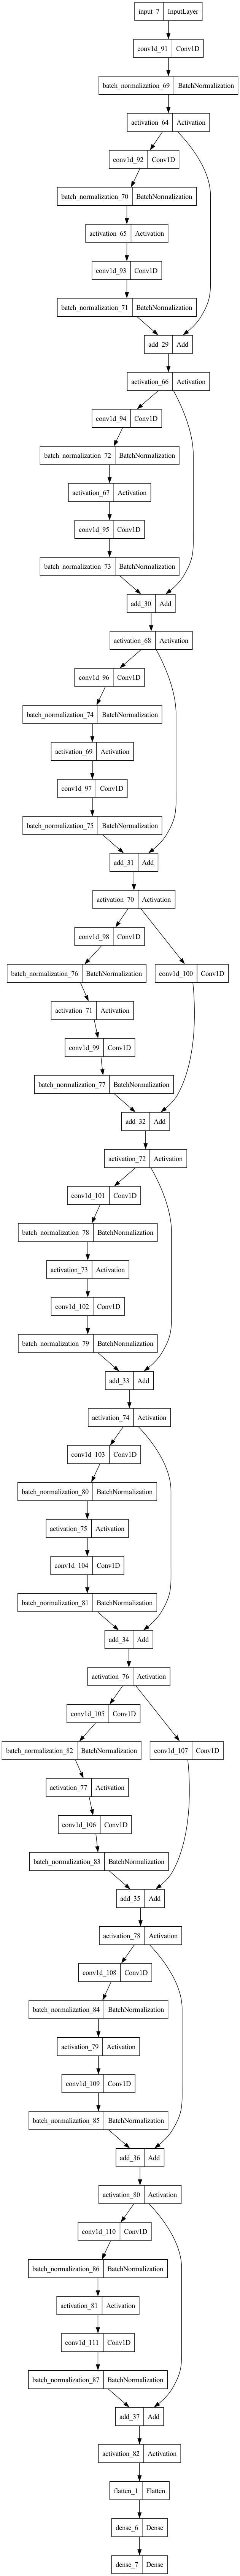

In [35]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, Add, Flatten, Dense

# Define parameter of the model
input_shape = (2776, 1)  # Assuming 1 feature in each time step
num_classes = 9
batch_size = 128
epochs = 200

def residual_block(x, filters, kernel_size=3, stride=1):
    y = Conv1D(filters, kernel_size=kernel_size, strides=stride, padding='same')(x)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)

    y = Conv1D(filters, kernel_size=kernel_size, strides=1, padding='same')(y)
    y = BatchNormalization()(y)

    # Adjust dimensions of the skip connection
    if stride > 1:
        x = Conv1D(filters, kernel_size=1, strides=stride, padding='same')(x)
    
    out = Add()([x, y])
    out = Activation('relu')(out)
    return out

# Define the ResNet + Conv1D model
def resnet_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Initial Conv1D layer
    x = Conv1D(64, kernel_size=7, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Residual Blocks
    for _ in range(3):
        x = residual_block(x, filters=64)

    x = residual_block(x, filters=128, stride=2)
    for _ in range(2):
        x = residual_block(x, filters=128)

    x = residual_block(x, filters=256, stride=2)
    for _ in range(2):
        x = residual_block(x, filters=256)

    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    outputs = Dense(num_classes, activation='linear')(x)

    model = Model(inputs=inputs, outputs=outputs, name='resnet_conv1d')
    return model

model = resnet_model(input_shape, num_classes)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Display the model summary
model.summary()

# Plot the model
tfk.utils.plot_model(model)


In [36]:
# Train the model

history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_test, y_test),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=50, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=10, factor=0.75, min_lr=1e-5)
    ]
).history

Epoch 1/200
  1/300 [..............................] - ETA: 47:04 - loss: 6.3740 - mae: 1.6737

If you want to give a more robust interpretation of the results, given the individual normalisation of the series, you can consider the Mean Absolute Error (MAE) as the average percentage error (scaled between 0 and 1) obtained on the predicted points compared to the ground truth.

# Plot results

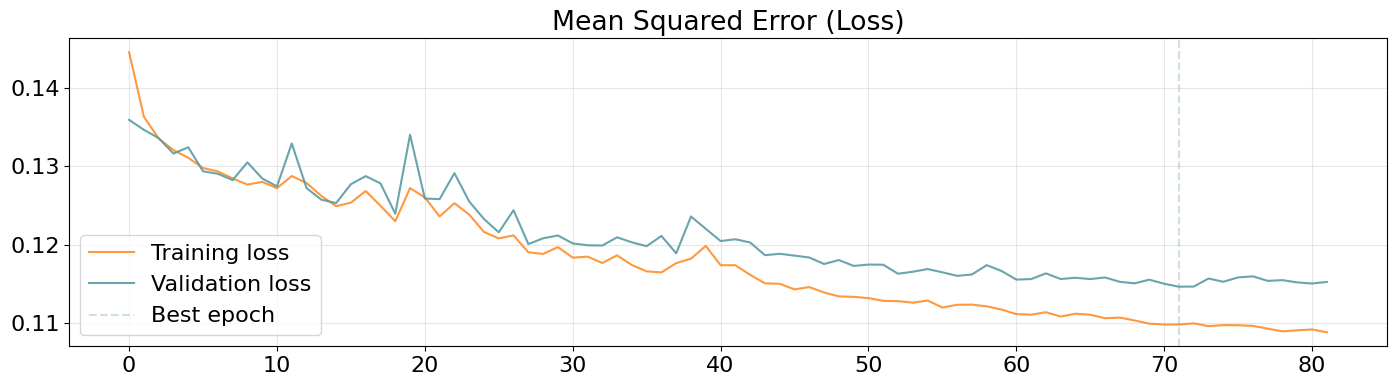

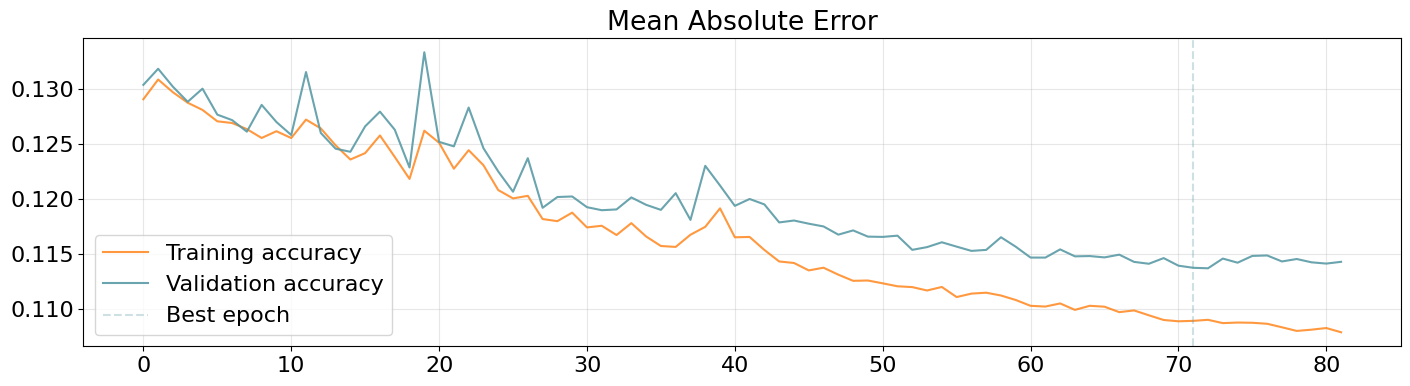

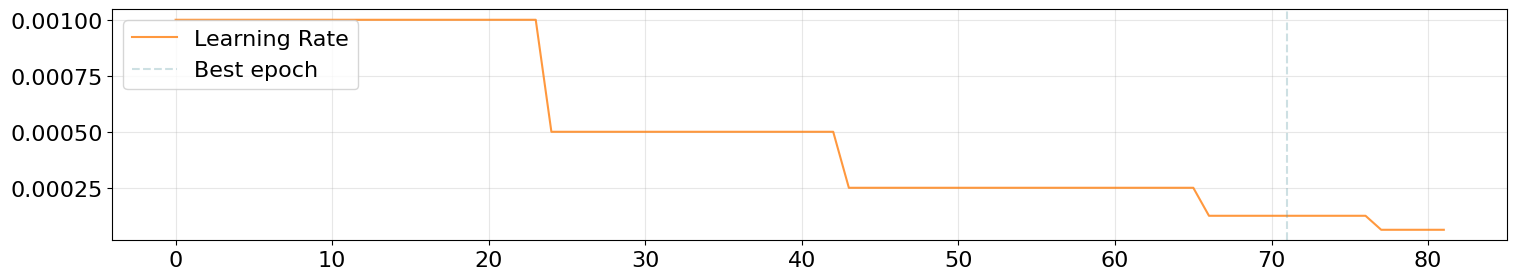

In [ ]:
# Plot results

best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['mse'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_mse'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Absolute Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
# Predict the test set 
predictions = model.predict(X_test)
print(predictions.shape)

mean_squared_error = tfk.metrics.mse(y_test.flatten(),predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_test.flatten(),predictions.flatten())
mean_squared_error, mean_absolute_error

300/300 [==============================] - 1s 2ms/step
(9600, 9)


(<tf.Tensor: shape=(), dtype=float32, numpy=0.11202508>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.11301828>)

In [ ]:
predictions.shape

(9600, 9)

In [ ]:
def inspect_multivariate_prediction(X, y, pred, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), pred[idx,:,i], color='green') 
        # le linee verdi hanno dei segmenti che sono sovrascitti, poiché i samples in X_test sono sovrappost (visto che stride != window)
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()
    
inspect_multivariate_prediction(X_test, y_test, predictions, target_labels, telescope)

NameError: name 'target_labels' is not defined

Accuracy: 0.4918
Precision: 0.327
Recall: 0.3728
F1: 0.3437


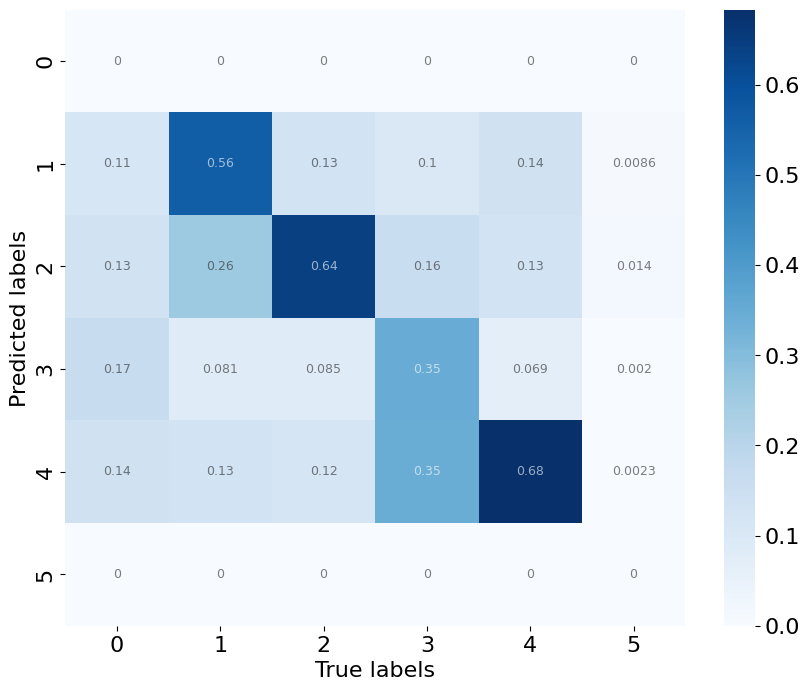

In [ ]:
# Compute the confusion matrix

cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

cm = cm /cm.astype(float).sum(axis=1);

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues', annot=True, annot_kws={'fontsize':9,'alpha':0.6})#, xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

# Save the model

In [ ]:
save_model(model, 'resnetplusconv1d')
# shutil.make_archive("SubmissionModel", 'zip', "./SubmissionModel")

NameError: name 'shutil' is not defined

In [ ]:
import os
import zipfile
from datetime import datetime
import tensorflow as tf
from os.path import basename

# Specify the name of the submission folder
submission_folder = "SubmissionModel"

# Save best epoch model
model.save(os.path.join(submission_folder, "SubmissionModel"))

# Save the model.py file in the main directory
with open("model.py", "w") as model_file:
    model_file.write("""

import os
import tensorflow as tf
import numpy as np

class model:
    def __init__(self, path):
        self.model = tf.keras.models.load_model(os.path.join(path, 'SubmissionModel'))

    def predict(self, X, categories):
        # Determine the number of zeros to add
        num_zeros_to_add = 2776 - X.shape[1]

        # Add zeros to the beginning of each sequence in X
        X_padded = np.pad(X, ((0, 0), (num_zeros_to_add, 0)), mode='constant')

        # Note: this is just an example.
        # Here the model.predict is called
        out = self.model.predict(X_padded)  # Shape [BSx9] for Phase 1 and [BSx18] for Phase 2

        return out
""")

# Create an empty metadata file in the main directory
open("metadata", "w").close()

# Get the current date and time
current_datetime = datetime.now()
formatted_datetime = current_datetime.strftime("%Y%m%d_%H%M%S")

# Create the zipfile with date and time in the name
zipfile_name = f"{submission_folder}_{formatted_datetime}.zip"

with zipfile.ZipFile(zipfile_name, 'w') as zip_file:
    # Add the entire "SubmissionModel" folder and its contents to the archive
    for foldername, subfolders, filenames in os.walk(submission_folder):
        for filename in filenames:
            file_path = os.path.join(foldername, filename)
            arcname = os.path.relpath(file_path, submission_folder)

            if (foldername in ["SubmissionModel", "SubmissionModel/model", "SubmissionModel/model/variables", "SubmissionModel/variables"]):
                continue

            # print(foldername)
            print(file_path)

            zip_file.write(file_path, arcname)

    # Add other files to the archive (model.py and metadata)
    zip_file.write("model.py", arcname="model.py")
    zip_file.write("metadata", arcname="metadata")

print(zipfile_name)

SubmissionModel/SubmissionModel/keras_metadata.pb
SubmissionModel/SubmissionModel/fingerprint.pb
SubmissionModel/SubmissionModel/saved_model.pb
SubmissionModel/SubmissionModel/variables/variables.data-00000-of-00001
SubmissionModel/SubmissionModel/variables/variables.index
SubmissionModel_20231213_143038.zip
